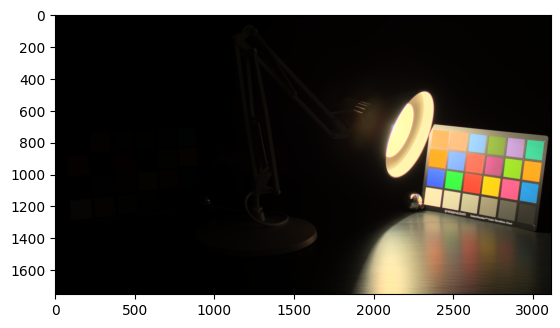

Output saved as reinhard.png


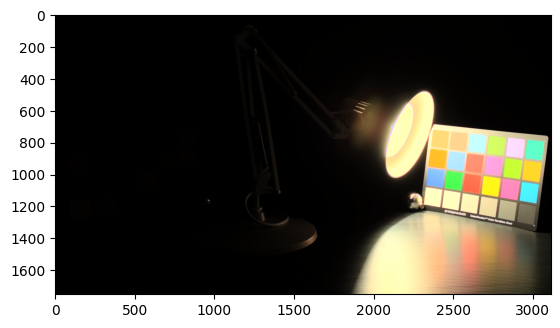

Output saved as aces.png
computing blur at sigma  2.0
showing
computing blur at sigma  4.0
showing
computing blur at sigma  8.0
showing
computing blur at sigma  16.0
showing
computing blur at sigma  32.0
showing
computing blur at sigma  64.0
showing
computing blur at sigma  128.0
showing
computing blur at sigma  256.0
showing
computing blur at sigma  512.0
showing
computing blur at sigma  1024.0
showing
computing blur at sigma  2048.0
showing
computing blur at sigma  4096.0
showing
computing blur at sigma  8192.0
showing
1
0.85
0.7224999999999999
0.6141249999999999
0.5220062499999999
0.4437053124999999
0.3771495156249999
0.32057708828124987
0.2724905250390624
0.23161694628320303
0.19687440434072256
0.16734324368961417


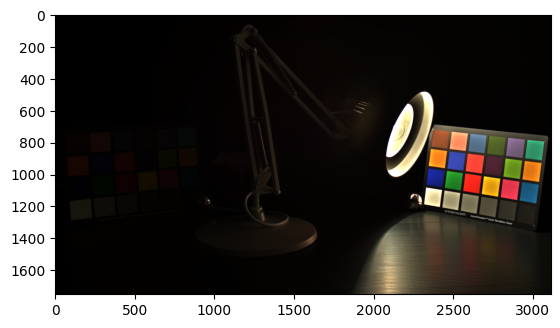

Output saved as dn_exposure.png


In [6]:
from brightness.dino import *
from brightness.plotting import *
from brightness.tone_mappers.reinhard import reinhard_tone_map

def aces(
    L: np.ndarray,
    a: float = 2.51,
    b: float = 0.03,
    c: float = 2.43,
    d: float = 0.59,
    e: float = 0.14,
):
    """ACES global tone mapper with default values as per
    https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
    """
    return (L * (a * L + b)) / (L * (c * L + d) + e)

def dn_exposure_model(
    L: np.ndarray,
    cs_ratio: float = 2.0,
    min_scale: float = 1.0,
    w: float = 0.85,
    a: float = 1.0,
    b: float = 1.0,
    c: float = 1.0,
    d: float = 1.0,
    scale_normalized_constants: bool = False,
) -> np.ndarray:
    """Very similar to brightness but takes a weighted average of the guassian blurs using weights that 
     are the activision of the channels in the brightness model
    """
    scales = generate_scales(L.shape, cs_ratio, min_scale)
    scales = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    #scales = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    weights = [w**i for i in range(len(scales))]
    print("scales =", scales)
    print("weights =", weights)

    # Initialize weighted_sum as a 2D array
    weighted_sum = np.zeros(L.shape[:2], dtype=L.dtype)
    sum_of_activations = 0.0

    p = 2.0
    p_L = np.power(L, 1.0/p)
    # Compute ratios and weighted sum using only two blurred images at a time
    center_response = gaussian_blur_cv(p_L, scales[0])
    
    for i in range(1, len(scales)):
        surround_response = gaussian_blur_cv(p_L, scales[i])
    
        assert center_response.ndim == 2 
        assert surround_response.ndim == 2
    
        _b = b
        _d = d

        _b = 0.001
        _d = 0.001
    
        activation = np.abs(weights[i - 1] * (
            #(a * center_response + _b) / (c * surround_response + _d) - _b / _d
            center_response / (surround_response + 0.00001) - 1
        ))
        print(weights[i-1])
        sum_of_activations += activation 
        weighted_sum += activation*np.power(center_response, p)
        center_response = surround_response
        
    return weighted_sum / sum_of_activations

def ported_generate_gaussian_blurs(image, sigma=1.0, k=1.6, N=9):
    blurred_images = []
#    current_sigma = sigma*0.35
    current_sigma = sigma

    for i in range(N):
        print("computing blur at sigma ", current_sigma)
        blurred = cv2.GaussianBlur(image, (0, 0), current_sigma)
        blurred_images.append((current_sigma, blurred))
        print("showing")
        current_sigma *= k

    return blurred_images

def ported_compute_brightness_weight(blurred_images, k = 0.85):
    responses = []

    weight = 1
    weight_sum = 0
    accum = np.zeros_like(blurred_images[0][1])
    for i in range(len(blurred_images) - 1):
        sigma_small, img_small = blurred_images[i]
        sigma_large, img_large = blurred_images[i + 1]

        response = weight*(img_small) / (img_large + 0.001) - 1
        accum += np.abs(response)*np.power(img_small, 2.0)
        print(weight)
        weight_sum  += weight
        weight *= k

    return accum / weight_sum

def ported_just_dn_tone_map(L, key=0.18):
    blurred = ported_generate_gaussian_blurs(np.power(L,1.0/2.0), 2.0, 2.0, 13)
    average = ported_compute_brightness_weight(blurred, 0.85)
    scaled_linear_luminances = (key/average)*L
    return scaled_linear_luminances




#file_path = "images/DelicateArch.exr"
file_path = "images/LuxoDoubleChecker.exr"
key = 0.18
image = read_image(file_path)
image = np.squeeze(image)

# Convert to XYZ and compute luminance and chromaticities
X, Y, Z = rgb_to_xyz(image)
luminance, x_chroma, y_chroma = xyz_to_lxy(X, Y, Z)
pre_exposed_luminance = pre_expose_image(luminance, key)

new_luminance = reinhard_tone_map(pre_exposed_luminance)
reinhard_rgb = lxy_to_rgb(new_luminance, x_chroma, y_chroma)
save_png("_output/reinhard.png", reinhard_rgb)
plt.imshow(reinhard_rgb)
plt.show()
print("Output saved as reinhard.png")

new_luminance = aces(pre_exposed_luminance)
aces_rgb = lxy_to_rgb(new_luminance, x_chroma, y_chroma)
save_png("_output/aces.png", aces_rgb)
plt.imshow(aces_rgb)
plt.show()
print("Output saved as aces.png")


L_exposure = ported_just_dn_tone_map(luminance)
#L_exposure = (0.18/dn_exposure_model(luminance))*luminance
exposure_rgb = lxy_to_rgb(L_exposure, x_chroma, y_chroma)
save_png("_output/dn_exposure.png", exposure_rgb)
plt.imshow(exposure_rgb)
plt.show()
print("Output saved as dn_exposure.png")


    

